In [1]:
from impala.dbapi import connect

conn = connect(
    host='127.0.0.1',  
    port=10006,       
    user='maria_dev',
    database='default',
    auth_mechanism='PLAIN' 
)

cursor = conn.cursor()
cursor.execute('SHOW DATABASES')
print(cursor.fetchall())

[('default',), ('education_cost',), ('foodmart',), ('salary_analysis',)]


In [7]:
from pyhive import hive
import pandas as pd

In [9]:
# 查询数据
query = """
SELECT
  Country,
  ROUND(AVG(Tuition_USD), 2) AS Avg_Tuition_USD,
  ROUND(AVG(Tuition_USD + Rent_USD * 12 * Duration_Years + Insurance_USD + Visa_Fee_USD), 2) AS Avg_Total_Cost_USD,
  ROUND(AVG(Living_Cost_Index), 2) AS Avg_Living_Cost_Index
FROM international_education_costs
GROUP BY Country
"""

df = pd.read_sql(query, conn)
df

C:\Users\tshcy\AppData\Local\Temp\ipykernel_30072\3225917453.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,country,avg_tuition_usd,avg_total_cost_usd,avg_living_cost_index
0,Algeria,1100.00,8172.00,35.68
1,Argentina,0.00,13103.33,39.62
2,Australia,34610.47,84463.95,68.25
3,Austria,1500.00,27804.44,71.07
4,Bahrain,7600.00,32666.00,62.86
...,...,...,...,...
66,USA,47742.31,124171.54,77.80
67,Ukraine,3520.00,15556.00,42.76
68,Uruguay,2700.00,16148.00,48.88
69,Uzbekistan,3620.00,12046.00,40.36


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
print(df.columns)


Index(['country', 'avg_tuition_usd', 'avg_total_cost_usd',
       'avg_living_cost_index'],
      dtype='object')


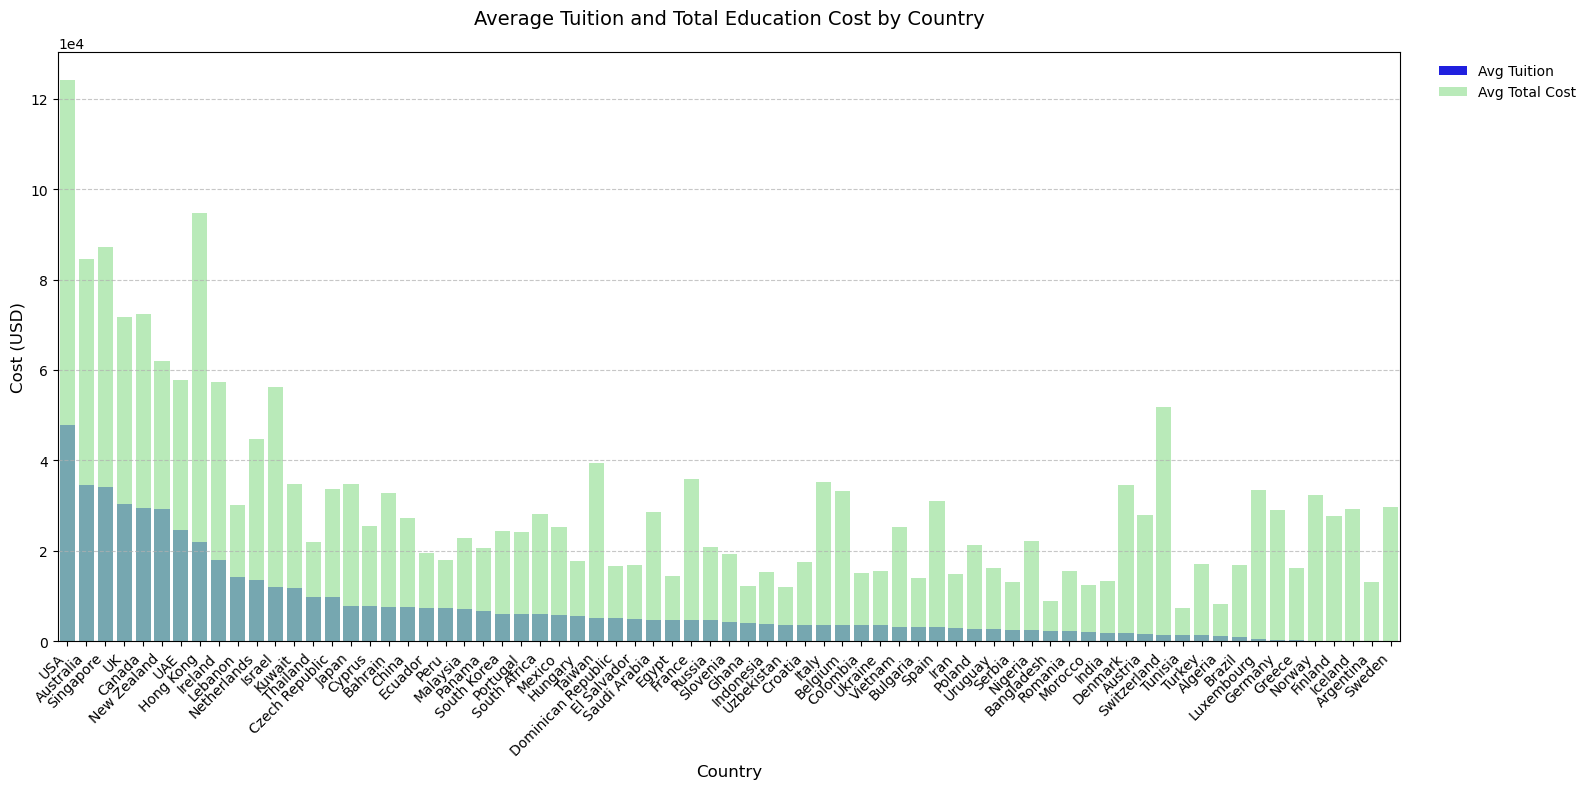

In [91]:
plt.figure(figsize=(16, 8))

# 排序数据
df_sorted = df.sort_values('avg_tuition_usd', ascending=False)

# 绘制双柱状图
sns.barplot(
    data=df_sorted, x='country', y='avg_tuition_usd', 
    color='blue', label='Avg Tuition'
)
sns.barplot(
    data=df_sorted, x='country', y='avg_total_cost_usd', 
    color='lightgreen', alpha=0.7, label='Avg Total Cost'
)

# 标签和标题
plt.title('Average Tuition and Total Education Cost by Country', fontsize=14, pad=20)
plt.xlabel('Country', fontsize=12)
plt.ylabel('Cost (USD)', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

# 网格和科学计数法
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ticklabel_format(axis='y', style='sci', scilimits=(4,4))

# 图例和布局
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', frameon=False)
plt.tight_layout()
plt.savefig("Average Tuition and Total Education Cost by Country.png")
plt.show()


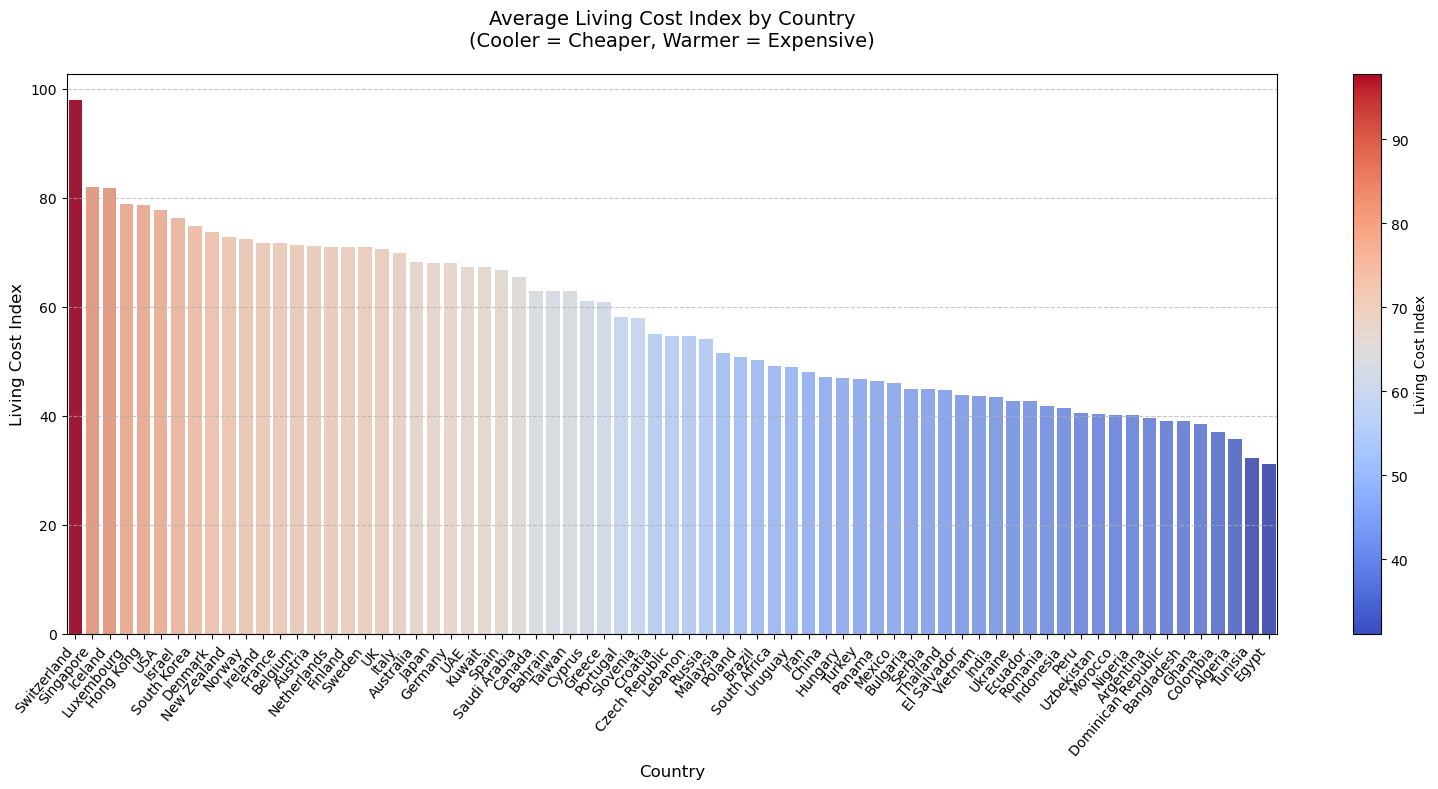

<Figure size 640x480 with 0 Axes>

In [93]:
#这个图展示不同国家的生活成本指数（数值越高，生活越贵），颜色从冷到暖代表成本高低。
plt.figure(figsize=(16, 8))  # 增大画布尺寸

# 按生活成本排序
df_sorted_index = df.sort_values('avg_living_cost_index', ascending=False)

# 绘制条形图（修复警告 + 颜色优化）
sns.barplot(
    data=df_sorted_index,
    x='country',
    y='avg_living_cost_index',
    hue='avg_living_cost_index',  # 关键修复：将数值映射到颜色
    palette='coolwarm',
    dodge=False,  # 禁用自动分簇
    legend=False  # 关闭默认图例
)

# 添加颜色条
norm = plt.Normalize(
    df['avg_living_cost_index'].min(),
    df['avg_living_cost_index'].max()
)
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm)
plt.colorbar(sm, label='Living Cost Index', ax=plt.gca())

# 标签和标题优化
plt.title('Average Living Cost Index by Country\n(Cooler = Cheaper, Warmer = Expensive)', 
         fontsize=14, pad=20)
plt.xlabel('Country', fontsize=12)
plt.ylabel('Living Cost Index', fontsize=12)
plt.xticks(rotation=50, ha='right', fontsize=10)  # 旋转标签 + 右对齐
plt.yticks(fontsize=10)

# 添加辅助线
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 优化布局
plt.tight_layout()

plt.savefig("A1/Average Living Cost Index by Country.png")
plt.show()


plt.savefig("A1/Average Living Cost Index by Country.png", bbox_inches="tight")

In [47]:
query_program = """
SELECT
  Country,
  Program,
  ROUND(AVG(Tuition_USD), 2) AS Avg_Tuition_By_Program
FROM international_education_costs
GROUP BY Country, Program
"""

df_program = pd.read_sql(query_program, conn)

# 转换列名为小写，防止后续出错
df_program.columns = [col.lower() for col in df_program.columns]




C:\Users\tshcy\AppData\Local\Temp\ipykernel_30072\2376901065.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_program = pd.read_sql(query_program, conn)


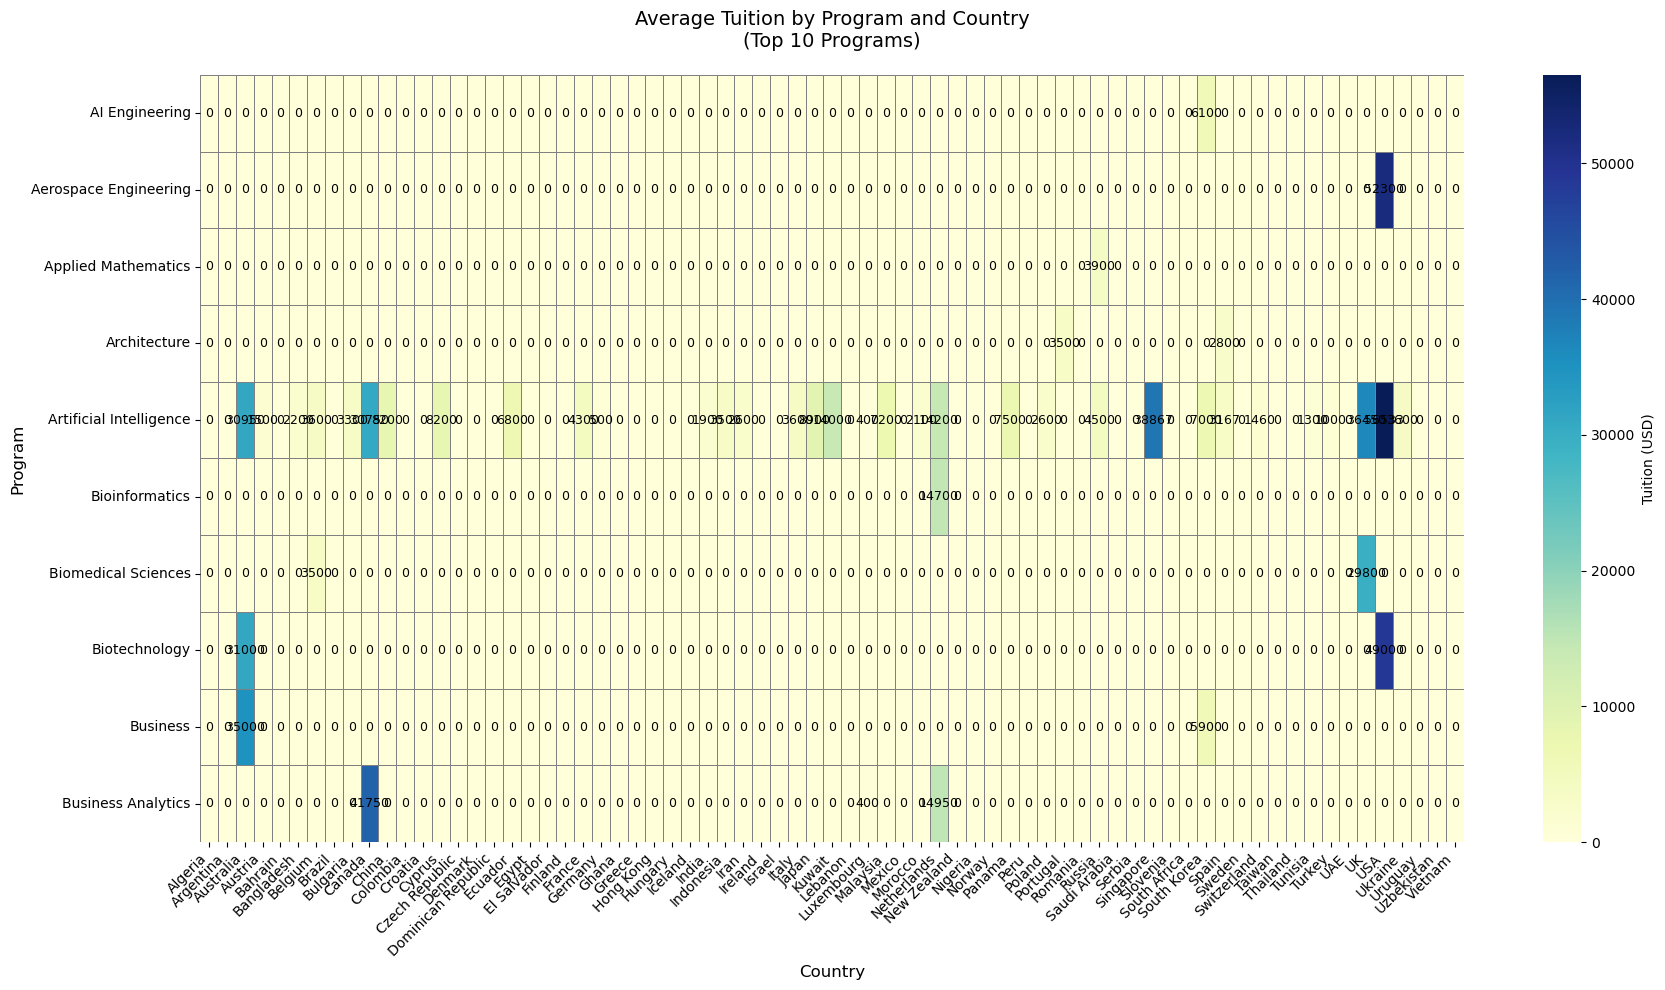

In [95]:
# 1. 数据清洗（修复转义警告）
df_program["avg_tuition_by_program"] = (
    df_program["avg_tuition_by_program"]
    .replace({r'\*': None, r',': ''}, regex=True)  # 使用原始字符串
    .astype(float)
)

# 2. 创建数据透视表
pivot = df_program.pivot_table(
    index='program',
    columns='country',
    values='avg_tuition_by_program',
    aggfunc='mean',
    fill_value=0
)

# 3. 筛选 Top 10 项目
pivot_filtered = pivot.head(10).sort_values(by=pivot.columns[0], ascending=False)

# 4. 绘制热力图（优化显示）
plt.figure(figsize=(18, 10))
sns.heatmap(
    pivot_filtered,
    annot=True,
    fmt=".0f",
    cmap="YlGnBu",
    annot_kws={"size": 9, "color": "black"},
    linewidths=0.5,
    linecolor="grey",
    cbar_kws={"label": "Tuition (USD)"}
)

plt.title("Average Tuition by Program and Country\n(Top 10 Programs)", fontsize=14, pad=20)
plt.xlabel("Country", fontsize=12)
plt.ylabel("Program", fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.savefig("A1/Average Tuition by Program and Country.png")
plt.show()



C:\Users\tshcy\AppData\Local\Temp\ipykernel_30072\3011359110.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_level = pd.read_sql(query_level, conn)


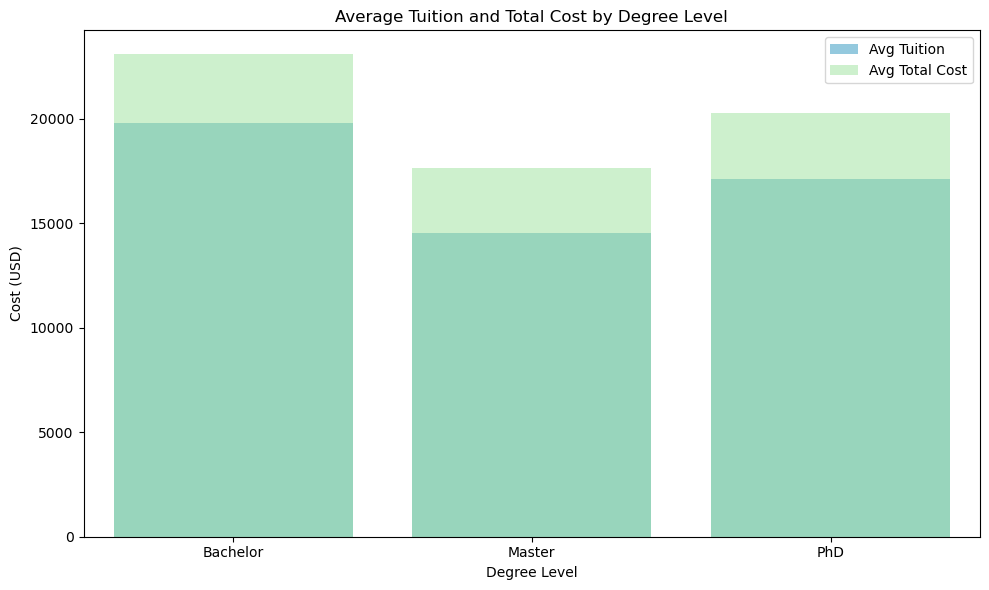

In [97]:
##不同学位对比
query_level = """
SELECT
  Level,
  ROUND(AVG(Tuition_USD), 2) AS avg_tuition_usd,
  ROUND(AVG(Rent_USD + Living_Cost_Index * 20 + Tuition_USD + Visa_Fee_USD + Insurance_USD), 2) AS avg_total_cost_usd,
  ROUND(AVG(Living_Cost_Index), 2) AS avg_living_cost_index
FROM international_education_costs
GROUP BY Level
"""

df_level = pd.read_sql(query_level, conn)
df_level.columns = [col.lower() for col in df_level.columns]

# 条形图比较不同 Level 的学费和总成本
plt.figure(figsize=(10, 6))

# 学费条
sns.barplot(data=df_level, x='level', y='avg_tuition_usd', color='skyblue', label='Avg Tuition')

# 总成本条，带透明度叠加
sns.barplot(data=df_level, x='level', y='avg_total_cost_usd', color='lightgreen', alpha=0.5, label='Avg Total Cost')

plt.title('Average Tuition and Total Cost by Degree Level')
plt.ylabel('Cost (USD)')
plt.xlabel('Degree Level')
plt.legend()
plt.tight_layout()
plt.savefig("A1/Average Tuition and Total Cost by Degree Level.png")
plt.show()



C:\Users\tshcy\AppData\Local\Temp\ipykernel_30072\874427056.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_level, x='level', y='avg_living_cost_index', palette='coolwarm')


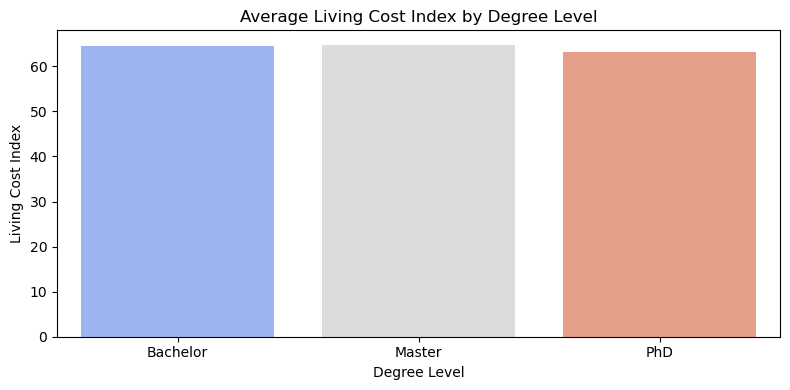

In [99]:
##不同学位的生活成本指数
plt.figure(figsize=(8, 4))
sns.barplot(data=df_level, x='level', y='avg_living_cost_index', palette='coolwarm')

plt.title('Average Living Cost Index by Degree Level')
plt.ylabel('Living Cost Index')
plt.xlabel('Degree Level')
plt.tight_layout()
plt.savefig("A1/Average Living Cost Index by Degree Level.png")
plt.show()
